# Experiment on Features(2), CatBoost Model
Applied the same calculation on train subset 9, and verified the common issue exists both in subset 1 and subset 9.
- Issue: carrier_min_estimate and carrier_max_estimate contributes a lot to the final result, maybe too much contribution.

In [2]:
import numpy as np
from catboost import Pool, CatBoostRegressor
import json
import pandas as pd
from tqdm import trange
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# load submodel 9 from files
cb = CatBoostRegressor()
model_9 = cb.load_model('../para/limited_data/catboost_9.cbm')

In [5]:
# prepare data for calculation
train_set = pd.read_csv('../data/limited_subtrain/train_9.tsv', sep='\t')
train_set['cross_city'] = train_set['cross_city'].astype('int')
train_set['cross_state'] = train_set['cross_state'].astype('int')
valid_set = pd.read_csv('../data/limited_subtrain/valid_9.tsv', sep='\t')
valid_set['cross_city'] = valid_set['cross_city'].astype('int')
valid_set['cross_state'] = valid_set['cross_state'].astype('int')

x_train9 = train_set.drop(['record_number', 'target'],axis=1)
y_train9 = train_set.target
x_valid9 = valid_set.drop(['record_number', 'target'],axis=1)
y_valid9 = valid_set.target

In [7]:
# prepare data for calculation -contd
# pool data are specific to Catboost model
train_pool9 = Pool(x_train9, 
              y_train9, 
              cat_features=[0, 4, 7, 8, 12, 13],
              feature_names=list(x_train9.columns))
test_pool9 = Pool(x_valid9,
             y_valid9,
             cat_features=[0, 4, 7, 8, 12, 13],
             feature_names=list(x_valid9.columns)) 

In [8]:
# ShapValues: A vector with contributions of each feature to the prediction for every input object and 
# the expected value of the model prediction for the object (average prediction given no knowledge about the object).
# calculation takes some time
feature_score_9 = model_9.get_feature_importance(data = train_pool9, type = 'ShapValues')
shap_val_9 = np.sum(feature_score_9, axis=0)
shap_val_9

array([-1.09738792e+04, -5.29656110e+03, -4.02083634e+05,  4.19009329e+05,
        1.46284304e+04, -2.81849060e+03,  0.00000000e+00,  1.54815121e+03,
       -3.12246034e+04,  1.72600490e+04, -2.62167404e+04,  5.15918211e+04,
        0.00000000e+00, -2.51186235e+04, -3.80940651e+02,  0.00000000e+00,
       -4.25947103e+02,  1.75456461e+07])

<AxesSubplot:>

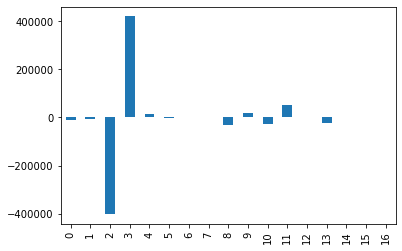

In [9]:
# Plot Shap values
## very skewed plots, with no.2 and no.3 feature contribute a lot!
pd.Series(np.delete(shap_val_9, -1)).plot.bar()

<AxesSubplot:>

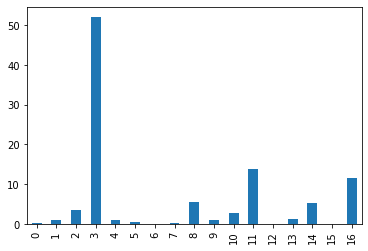

In [12]:
# equal to feature_importance for non-ranking metrics 
# Now use Prediction Values changes to see if the problem still exists, and yes it is.
pred_val_change_9 = model_9.get_feature_importance(data = train_pool9,
                                              type = 'PredictionValuesChange')

pd.Series(pred_val_change_9).plot.bar()

<AxesSubplot:>

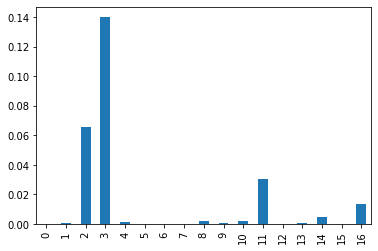

In [14]:
# loss function change has the same issue
loss_change_score_9 = model_9.get_feature_importance(data = train_pool9,
                                              type = 'LossFunctionChange')
pd.Series(loss_change_score_9).plot.bar()

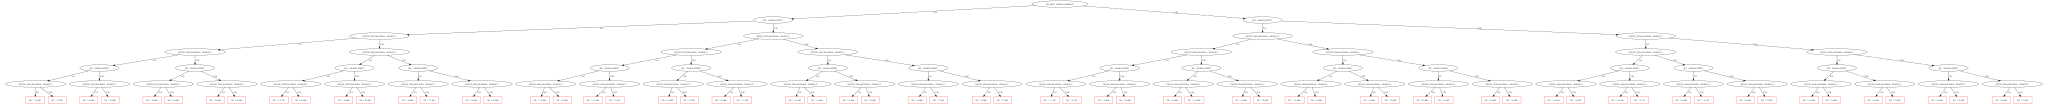

In [11]:
pool = Pool(x_train9, y_train9, cat_features=[0, 4, 7, 8, 12, 13], feature_names=list(x_train9.columns))
model_9.plot_tree(
    tree_idx=0,
    pool=pool
)
